# 02 - Análise exploratória (cs.AI.csv)

## Integrantes da equipe

>   Eduardo Marcelino Junior, 2028409, @eduardo.marcelino, BSI, UTFPR
>
>   Otávio Baziewicz Filho, 1942808, @worgho2, BSI, UTFPR
>
>   Rodrigo William Chavoni, 1996169, @rodrigochavoni, BSI, UTFPR

<!-- -   Para o projeto iremos utilizar 5 subcampos da ciência da computação, que são:
    -   df_AI: Artificial Intelligence
    -   df_DC: Distributed, Parallel, and Cluster Computing
    -   df_IR: Information Retrieval
    -   df_LG: Machine Learning
    -   df_NE: Neural and Evolutionary Computing
-   As bases possuem as mesmas colunas, que são:
    -   ID
    -   Updated
    -   Published
    -   Title
    -   Summary - Resumo do Artigo
    -   Authors
    -   Categories
-   O principal objetivo é analisar a coluna 'Summary', que contém os resumos dos artigos.
-   Primeiramente uma análise individual para cada categoria. Podendo serem feitas:
    -   Nuvem de palavras;
    -   Análise de Tópicos;
    -   (pensar em mais...)
-   Após a primeira análise individual, tentar relacionar as subcategorias.  -->

## Bibliotecas

In [1]:
# Geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
import pyLDAvis.lda_model

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

## Carregamento

In [3]:
# Carregamento dos dados 
def load_data(filename):
    return pd.read_csv(f"../output/data/{filename}")

data = load_data("cs.AI.csv").sample(1000)

## Apresentação

In [4]:
# Apresentação dos dados
def show_data_info(data: pd.DataFrame):
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.values}")
    print("Sample:")
    display(data.head())

show_data_info(data)

Shape: (1000, 7)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories
6080,http://arxiv.org/abs/2108.11762v1,2021-08-26T12:49:07Z,2021-08-26T12:49:07Z,Disentangling What and Where for 3D Object-Cen...,Although modern object detection and classif...,"Toon Van de Maele, Tim Verbelen, Ozan Catal, B...",cs.AI
1735,http://arxiv.org/abs/1301.6700v1,2013-01-23T15:58:22Z,2013-01-23T15:58:22Z,A New Model of Plan Recognition,"We present a new abductive, probabilistic th...","Robert P. Goldman, Christopher W. Geib, Christ...",cs.AI
130,http://arxiv.org/abs/cs/0003039v1,2000-03-08T21:49:57Z,2000-03-08T21:49:57Z,DES: a Challenge Problem for Nonmonotonic Reas...,"The US Data Encryption Standard, DES for sho...","Maarit Hietalahti, Fabio Massacci, Ilkka Niemela","cs.AI, I.2.3; I.2.4"
3308,http://arxiv.org/abs/1506.08919v1,2015-06-30T02:09:02Z,2015-06-30T02:09:02Z,Characterization of Logic Program Revision as ...,We address the problem of belief revision of...,"Nicolas Schwind, Katsumi Inoue",cs.AI
2418,http://arxiv.org/abs/1304.2751v1,2013-03-27T19:49:35Z,2013-03-27T19:49:35Z,Integrating Logical and Probabilistic Reasonin...,We describe a representation and a set of in...,"John S. Breese, Edison Tse",cs.AI


## Normalização dos dados

In [5]:
# Normalização dos dados (remoção de stopwords, pontuação, etc)
def normalize_text(text: str):
    stopword_list = nltk.corpus.stopwords.words('english')
    return  " ".join([word for word in word_tokenize(text.lower()) if word not in stopword_list and word.isalpha()])


# Geração de coluna normalizada com base em outra coluna
def generate_normalized_column(data: pd.DataFrame, from_column: str):
    new_column_name = f"{from_column}_Normalized"
    print(f"New column name: {new_column_name}")
    data[new_column_name] = data.apply(lambda linha: normalize_text(str(linha[from_column])), axis = 1)
    return new_column_name


normalized_summary_column_name = generate_normalized_column(data=data, from_column="Summary")
show_data_info(data)

New column name: Summary_Normalized


Shape: (1000, 8)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized
6080,http://arxiv.org/abs/2108.11762v1,2021-08-26T12:49:07Z,2021-08-26T12:49:07Z,Disentangling What and Where for 3D Object-Cen...,Although modern object detection and classif...,"Toon Van de Maele, Tim Verbelen, Ozan Catal, B...",cs.AI,although modern object detection classificatio...
1735,http://arxiv.org/abs/1301.6700v1,2013-01-23T15:58:22Z,2013-01-23T15:58:22Z,A New Model of Plan Recognition,"We present a new abductive, probabilistic th...","Robert P. Goldman, Christopher W. Geib, Christ...",cs.AI,present new abductive probabilistic theory pla...
130,http://arxiv.org/abs/cs/0003039v1,2000-03-08T21:49:57Z,2000-03-08T21:49:57Z,DES: a Challenge Problem for Nonmonotonic Reas...,"The US Data Encryption Standard, DES for sho...","Maarit Hietalahti, Fabio Massacci, Ilkka Niemela","cs.AI, I.2.3; I.2.4",us data encryption standard des short put forw...
3308,http://arxiv.org/abs/1506.08919v1,2015-06-30T02:09:02Z,2015-06-30T02:09:02Z,Characterization of Logic Program Revision as ...,We address the problem of belief revision of...,"Nicolas Schwind, Katsumi Inoue",cs.AI,address problem belief revision logic programs...
2418,http://arxiv.org/abs/1304.2751v1,2013-03-27T19:49:35Z,2013-03-27T19:49:35Z,Integrating Logical and Probabilistic Reasonin...,We describe a representation and a set of in...,"John S. Breese, Edison Tse",cs.AI,describe representation set inference methods ...


## Histograma e Nuvem de Palavras

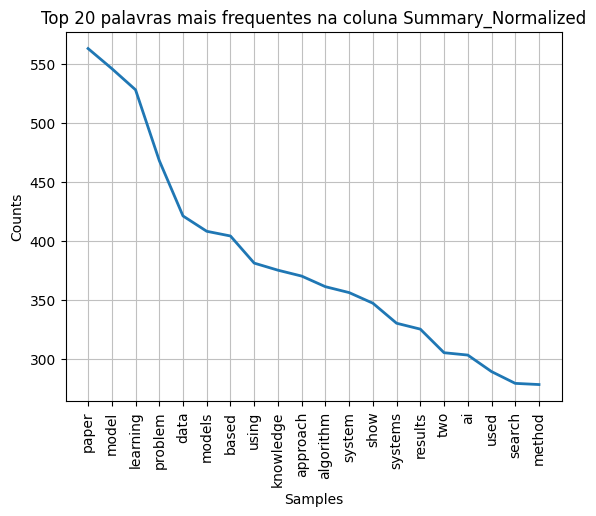

C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


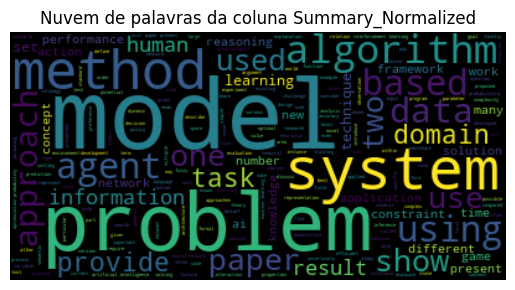

In [6]:
# Geração do histograma de frequência de palavras
def plot_word_frequency_histogram_and_wordcloud(data: pd.DataFrame, column: str, top: int):
    column_data = " ".join(data[column])

    # Histograma
    fdist = FreqDist(column_data.split(" "))
    fdist.plot(top, title=f"Top {top} palavras mais frequentes na coluna {column}")

    # Wordcloud
    wordcloud = WordCloud().generate(column_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuvem de palavras da coluna {column}")
    plt.axis("off")
    plt.show()

plot_word_frequency_histogram_and_wordcloud(data=data, column=normalized_summary_column_name, top=20)

## Polaridade e Subjetividade

In [7]:
# Adição de coluna de polaridade e subjetividade com base em outra coluna
def generate_polarity_and_subjectivity_columns(data: pd.DataFrame, from_column: str):
    new_polarity_column_name = f"{from_column}_Polarity"
    data[new_polarity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.polarity)

    new_subjectivity_column_name = f"{from_column}_Subjectivity"
    data[new_subjectivity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.subjectivity)

    return new_polarity_column_name, new_subjectivity_column_name

normalized_summary_polarity_column_name, normalized_summary_subjectivity_column_name = generate_polarity_and_subjectivity_columns(data=data, from_column=normalized_summary_column_name)
show_data_info(data)

Shape: (1000, 10)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized' 'Summary_Normalized_Polarity'
 'Summary_Normalized_Subjectivity']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized,Summary_Normalized_Polarity,Summary_Normalized_Subjectivity
6080,http://arxiv.org/abs/2108.11762v1,2021-08-26T12:49:07Z,2021-08-26T12:49:07Z,Disentangling What and Where for 3D Object-Cen...,Although modern object detection and classif...,"Toon Van de Maele, Tim Verbelen, Ozan Catal, B...",cs.AI,although modern object detection classificatio...,0.137328,0.428479
1735,http://arxiv.org/abs/1301.6700v1,2013-01-23T15:58:22Z,2013-01-23T15:58:22Z,A New Model of Plan Recognition,"We present a new abductive, probabilistic th...","Robert P. Goldman, Christopher W. Geib, Christ...",cs.AI,present new abductive probabilistic theory pla...,0.134091,0.351136
130,http://arxiv.org/abs/cs/0003039v1,2000-03-08T21:49:57Z,2000-03-08T21:49:57Z,DES: a Challenge Problem for Nonmonotonic Reas...,"The US Data Encryption Standard, DES for sho...","Maarit Hietalahti, Fabio Massacci, Ilkka Niemela","cs.AI, I.2.3; I.2.4",us data encryption standard des short put forw...,0.145748,0.436565
3308,http://arxiv.org/abs/1506.08919v1,2015-06-30T02:09:02Z,2015-06-30T02:09:02Z,Characterization of Logic Program Revision as ...,We address the problem of belief revision of...,"Nicolas Schwind, Katsumi Inoue",cs.AI,address problem belief revision logic programs...,0.158535,0.460859
2418,http://arxiv.org/abs/1304.2751v1,2013-03-27T19:49:35Z,2013-03-27T19:49:35Z,Integrating Logical and Probabilistic Reasonin...,We describe a representation and a set of in...,"John S. Breese, Edison Tse",cs.AI,describe representation set inference methods ...,0.033333,0.352778


## Lemmatization

In [8]:
# Aplicação de lematização em coluna, retornando uma lista de palavras em sua forma raiz
def apply_lemmatization_to_column(data: pd.DataFrame, column: str, allowed_postags: list[str] = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm")

    column_words = data[column].map(lambda text: TextBlob(text).words)

    lemma_column_words = []
    for words in column_words:
        doc = nlp(" ".join(words))
        lemma_column_words.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))

    return lemma_column_words

summary_lemma = apply_lemmatization_to_column(data=data, column=normalized_summary_column_name)

## Vetorização

In [9]:
summary_vectorizer = CountVectorizer(
    analyzer='word',       
    min_df=10,                        # minimum required occurences of a word 
    stop_words='english',             # remove stop words
    lowercase=True,                   # convert all words to lowercase
    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
    # max_features=50000,             # max number of unique words
)

vectorized_summary_lemma = summary_vectorizer.fit_transform(summary_lemma)

## Sparsity

In [10]:
def get_vectorized_lemma_sparcity(vectorized_lemma: np.ndarray):
    dense_vectorized_lemma = vectorized_lemma.todense()
    return ((dense_vectorized_lemma > 0).sum()/dense_vectorized_lemma.size)*100

print(f"Sparcity: {get_vectorized_lemma_sparcity(vectorized_lemma=vectorized_summary_lemma)}%")

Sparcity: 4.003287671232877%


## LDA Grid Search

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -86893.31771670026
Model Perplexity:  637.4970898395563


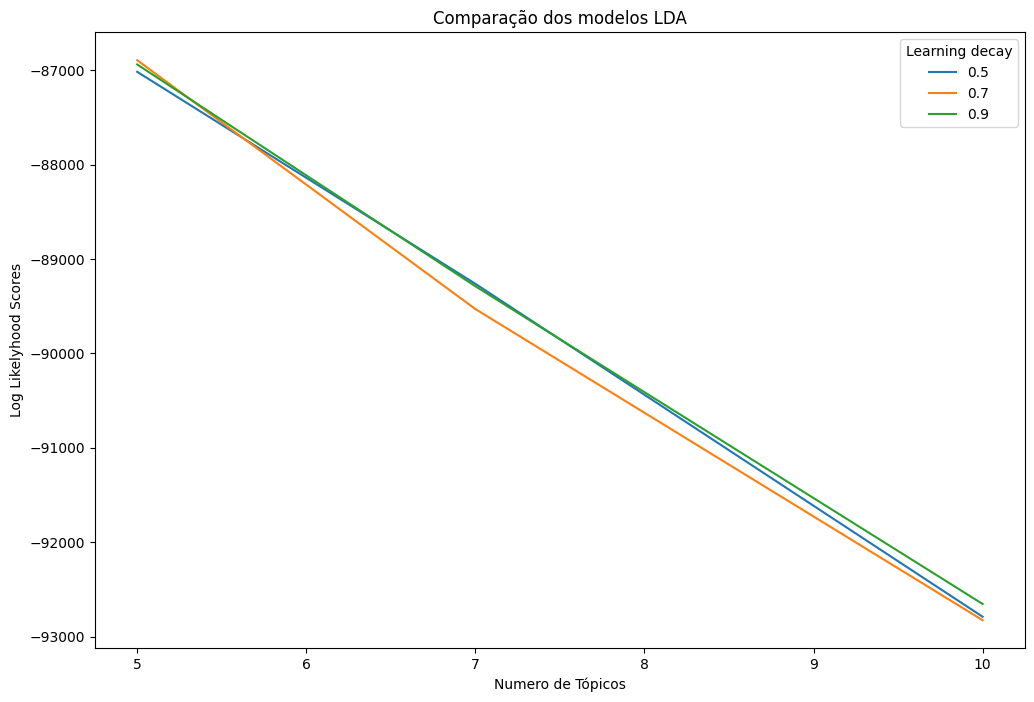

In [11]:
# Geração de modelo LDA com base em parâmetros otimizados pelo GridSearch
lda = LatentDirichletAllocation()
search_params = {
    'n_components': [5, 7, 10],
    'learning_decay': [.5, .7, .9]
}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vectorized_summary_lemma)

# Parâmetros do melhor modelo
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_summary_lemma))


# Visualização dos parâmetros otimizados pelo GridSearch
plt.figure(figsize=(12, 8))
for i in range(len(search_params['learning_decay'])):
    plt.plot(
        search_params['n_components'],
        [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==search_params['learning_decay'][i]],
        label=str(search_params['learning_decay'][i])
    )
plt.title("Comparação dos modelos LDA")
plt.xlabel("Numero de Tópicos")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


## Análise de Tópicos

In [12]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_summary_lemma)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data[normalized_summary_column_name]))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,0.00,0.00,0.00,0.25,0.75
Doc1,0.00,0.15,0.00,0.84,0.00
Doc2,0.00,0.60,0.00,0.21,0.19
Doc3,0.00,0.99,0.00,0.00,0.00
Doc4,0.00,0.68,0.15,0.00,0.16
...,...,...,...,...,...
Doc995,0.39,0.13,0.09,0.00,0.38
Doc996,0.00,0.30,0.28,0.20,0.21
Doc997,0.01,0.01,0.33,0.01,0.65
Doc998,0.00,0.07,0.93,0.00,0.00


In [13]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.250000,0.750000,4
Doc1,0.000000,0.150000,0.000000,0.840000,0.000000,3
Doc2,0.000000,0.600000,0.000000,0.210000,0.190000,1
Doc3,0.000000,0.990000,0.000000,0.000000,0.000000,1
Doc4,0.000000,0.680000,0.150000,0.000000,0.160000,1
Doc5,0.000000,0.570000,0.420000,0.000000,0.000000,1
Doc6,0.400000,0.040000,0.000000,0.560000,0.000000,3
Doc7,0.270000,0.010000,0.230000,0.090000,0.410000,4
Doc8,0.380000,0.000000,0.000000,0.610000,0.000000,3
Doc9,0.000000,0.000000,0.000000,0.350000,0.640000,4


In [14]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,266
1,1,230
2,0,195
3,2,157
4,3,152


In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = summary_vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,abstract,abstraction,accelerate,accept,access,accord,account,accuracy,...,weak,web,weight,wide,widely,word,work,world,year,yield
Topic0,33.312022,15.371943,3.618534,9.817448,4.277474,0.208980,5.029932,3.436939,3.165580,0.588135,...,5.309331,11.359130,0.200829,8.014866,10.539815,10.248220,72.401552,31.294006,19.634503,0.205598
Topic1,0.226105,3.309031,21.180726,0.206207,0.201783,9.611833,3.648068,18.629243,10.418670,5.237157,...,12.412539,0.200964,37.421798,1.662279,0.202975,9.832222,38.762782,18.037387,5.217919,4.491743
Topic2,6.148333,6.920915,0.201790,0.203014,1.214812,0.202137,0.200808,2.416372,0.203597,15.656817,...,2.098680,0.202455,16.065232,3.417593,5.077814,0.205179,29.044062,3.034623,0.620731,7.536305
Topic3,6.997136,26.772109,14.911947,25.748938,11.088872,0.202760,2.611694,3.127601,5.818231,0.202730,...,0.202110,0.915559,3.104423,11.137258,6.179119,0.370215,52.301504,45.979553,1.630844,8.090999
Topic4,14.316405,20.626002,10.087003,14.024393,0.217060,6.774290,8.509497,12.389845,25.393922,50.315161,...,5.977341,19.321893,0.207719,13.768004,7.000277,9.344163,74.490101,4.654431,22.896004,9.675355


In [16]:
# Show top n keywords for each topic
def show_topics(vectorizer=summary_vectorizer, lda_model=lda_output, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=summary_vectorizer, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,human,intelligence,game,artificial,use,research,learn,paper,machine,agent,design,learning,application,process,environment
Topic 1,set,logic,model,paper,use,semantic,probabilistic,problem,theory,probability,inference,base,approach,constraint,program
Topic 2,problem,search,use,method,algorithm,decision,solution,number,time,state,constraint,tree,function,propose,space
Topic 3,agent,problem,plan,action,planning,use,domain,task,learn,approach,solve,goal,model,time,state
Topic 4,model,datum,use,network,knowledge,method,propose,base,learn,approach,result,paper,provide,prediction,domain


### LDAVis

-   Topic Bubble:
    -   Quanto maior a bolha, maior a frequência do tópico nos documentos.
    -   Como o melhor modelo lda foi com 5 tópicos, isto é, um número pequeno de tópicos então as bolhas serão grandes bolhas não sobrepostas espalhadas pelo gráfico.
    -   A distância entre os tópicos é uma aproximação da relação semântica entre os tópicos.
    -   Pelas bolhas estarem bem separadas, os tópicos provavelmente não compartilham palavras.

-   Horizontal Bar Graph:
    -   O gráfico de barras azul mostra a distribuição de frequência das palavras nos documentos.
    -   A área sombreada em vermelho descreve a frequência de cada palavra em um tópico.
    -   Ao passar o mouse nas palavras do lado direito o tamanho das bolhas que possuem aquela palavra com mais frequencia aumentam de tamanho. Da mesma forma, tópicos que não possuem a palavra selecionada diminuem.
    -   Diminuindo o parâmetro lambda, aumenta o peso da razão entre a frequência da palavra dado o tópico / frequência geral da palavra nos documentos. Palavras importantes para um determinado tópico sobem.       

In [17]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, vectorized_summary_lemma, summary_vectorizer, mds='tsne')


pyLDAvis.display(panel)

In [18]:
pyLDAvis.save_html(panel, 'C:\\Users\\rodri\\Documents\\recuperacao-de-informacao\\02 - Analise exploratoria\\arxiv\\ldavis_html\\lda_ia.html')